In [1]:
from collections import OrderedDict, namedtuple
import time

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import theano as th
import theano.tensor as T

%load_ext autoreload
%autoreload 2

In [2]:
from tdlearn.examples import PendulumSwingUpCartPole
from utils.cartpole import CartPole
from utils import VariableStore, Linear, SGD, momentum

In [3]:
seed = int(time.time())
print seed
rng = T.shared_randomstreams.RandomStreams(seed)

1446156040


In [4]:
# Set up continuous MDP instance.
mdp = PendulumSwingUpCartPole()
STATE_DIM = mdp.dim_S
ACTION_DIM = mdp.dim_A

In [25]:
EXPLORE_RANGE = 0.5

Critic = namedtuple("Critic", ["pred", "targets", "cost", "updates"])


class DPGModel(object):
    
    def __init__(self, state_dim, action_dim, explore_range=0.5, track=True,
                 _parent=None, name="dpg"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.explore_range = explore_range
        self.name = name
        
        self.parent = _parent
        if _parent is None:
            self._vs_actor = VariableStore("%s/vs_a" % name)
            self._vs_critic = VariableStore("%s/vs_c" % name)
            self._vs_prefix = self.name
            self._make_vars()
        else:
            self._vs_actor = VariableStore.snapshot(_parent._vs_actor)
            self._vs_critic = VariableStore.snapshot(_parent._vs_critic)
            self._vs_prefix = _parent.name
            self._pull_vars(_parent)
        
        self._make_graph()
        self._make_updates()
        self._make_functions()
        
        if track:
            self.track = DPGModel(state_dim, action_dim, explore_range,
                                  track=False, _parent=self,
                                  name="%s_track" % name)
        
    def _make_vars(self):
        self.X = T.matrix("X")

        # Optionally directly provide actions predicted
        self.actions = T.matrix("actions")
        # Q target values
        self.q_targets = T.vector("q_targets")
        # Learning rates
        self.lr_actor = T.scalar("lr_actor")
        self.lr_critic = T.scalar("lr_critic")
        
    def _pull_vars(self, parent):
        self.X = parent.X
        self.actions = parent.actions
        self.q_targets = parent.q_targets
        self.lr_actor = parent.lr_actor
        self.lr_critic = parent.lr_critic
        
        # Target network: tracking coefficient
        self.tau = T.scalar("tau")
        
    def _make_graph(self):
        # Deterministic policy: linear map
        self.a_pred = Linear(self.X, self.state_dim, self.action_dim,
                             self._vs_actor, name="%s/a" % self._vs_prefix)

        # Exploration policy: add noise
        self.a_explore = self.a_pred + rng.normal(self.a_pred.shape,
                                                  0, self.explore_range, ndim=2)

        # Create a few different Critic instances (Q-functions). These all
        # share parameters; they only differ in the sources of their inputs.
        #
        # Critic 1: actions given
        self.critic_given = self._make_critic(self.actions, self.q_targets)
        # Critic 2: with deterministic policy
        self.critic_det = self._make_critic(self.a_pred, self.q_targets)
        # Critic 3: with noised / exploration policy
        self.critic_exp = self._make_critic(self.a_explore, self.q_targets)
        
    def _make_critic(self, actions, targets):
        # Q-function is a linear map on state+action pair.
        q_pred = Linear(T.concatenate([self.X, actions], axis=1),
                        self.state_dim + self.action_dim, 1, self._vs_critic,
                        "%s/q" % self._vs_prefix)
        q_pred = q_pred.reshape((-1,))
        
        # MSE loss on TD backup targets.
        q_cost = ((targets - q_pred) ** 2).mean()
        q_updates = momentum(q_cost, self._vs_critic.vars.values(),
                             self.lr_critic)
        
        return Critic(q_pred, targets, q_cost, q_updates)
    
    def _make_updates(self):
        # Actor-critic learning w/ critic 3
        # NB, need to flatten all timesteps into a single batch
        self.updates = OrderedDict(self.critic_exp.updates)
        # Add policy gradient updates
        self.updates.update(momentum(-self.critic_exp.pred.mean(),
                                     self._vs_actor.vars.values(),
                                     self.lr_actor))
        
        # Target network: update w.r.t. parent
        if self.parent is not None:
            self.target_updates = OrderedDict()
            for vs, parent_vs in [(self._vs_actor, self.parent._vs_actor),
                                  (self._vs_critic, self.parent._vs_critic)]:
                for param_name, param_var in vs.vars.iteritems():
                    self.target_updates[param_var] = (
                        self.tau * vs.vars[param_name]
                        + (1 - self.tau) * parent_vs.vars[param_name])
        
    def _make_functions(self):
        # On-policy action prediction function
        self.f_action_on = th.function([self.X], self.a_pred)
        # Off-policy action prediction function
        self.f_action_off = th.function([self.X], self.a_explore)

        # Q-function
        self.f_q = th.function([self.X, self.actions], self.critic_given.pred)

        # Actor-critic update
        self.f_update = th.function([self.X, self.q_targets,
                                     self.lr_actor, self.lr_critic],
                                    (self.critic_exp.cost, self.critic_exp.pred),
                                    updates=self.updates)
        
        # Target networks only: update w.r.t. parent
        if self.parent is not None:
            self.f_track_update = th.function([self.tau],
                                              updates=self.target_updates)
        
        
dpg = DPGModel(STATE_DIM, ACTION_DIM, EXPLORE_RANGE, track=True)

In [26]:
def preprocess_state(state, clip_range=20):
    state = np.clip(state, -clip_range, clip_range)
    return state

def preprocess_action(action, clip_range=20):
    action = np.clip(action, -clip_range, clip_range)
    return action

def update_buffers(buffers, states, actions, rewards, states_next):
    R_states, R_actions, R_rewards, R_states_next = buffers
    
    R_states = np.append(R_states, states, axis=0)
    R_states_next = np.append(R_states_next, states_next, axis=0)
    R_actions = np.append(R_actions, actions)
    R_rewards = np.append(R_rewards, rewards)
    
    buffers = (R_states, R_actions, R_rewards, R_states_next)
    return buffers

def run_episode(mdp, buffers, max_len=100, on_policy=True):
    policy = dpg.f_action_on if on_policy else dpg.f_action_off
    def policy_fn(state):
        state = preprocess_state(state).reshape((-1, mdp.dim_S))
        return policy(state)
    
    states, actions, rewards, states_next = [], [], [], []
    trajectory_gen = mdp.sample_transition(max_len, policy_fn)

    for s, a, s_n, r in trajectory_gen:
        states.append(preprocess_state(s))
        actions.append(preprocess_action(a))
        states_next.append(preprocess_state(s_n))
        rewards.append(r)
    
    if buffers is not None:
        buffers = update_buffers(buffers, states, actions, rewards, states_next)
    return buffers, (states, actions, rewards, states_next)

def train_batch(dpg, buffers, batch_size, gamma=0.9, tau=0.5, lr_actor=0.01,
                lr_critic=0.001):
    R_states, R_actions, R_rewards, R_states_next = buffers
    
    if len(R_states) - 1 < batch_size:
        # Not enough data. Keep collecting trajectories.
        return 0.0

    # Sample a training minibatch.
    idxs = np.random.choice(len(R_states) - 1, size=batch_size, replace=False)
    b_states, b_actions, b_rewards, b_states_next = \
        R_states[idxs], R_actions[idxs], R_rewards[idxs], R_states_next[idxs]
    
    # Compute targets (TD error backups) given current Q function.
    next_actions = dpg.track.f_action_on(b_states_next)
    b_targets = b_rewards + gamma * dpg.track.f_q(b_states_next, next_actions).reshape((-1,))
    
    # SGD update.
    cost_t, _ = dpg.f_update(b_states, b_targets, lr_actor, lr_critic)
    # Update tracking model.
    dpg.track.f_track_update(tau)
    
    return cost_t

In [27]:
# Keep a replay buffer of states, actions, rewards, targets
R_states = np.empty((0, STATE_DIM), dtype=th.config.floatX)
R_actions = np.empty((0,), dtype=np.int32)
R_rewards = np.empty((0,), dtype=np.int32)
R_states_next = np.empty_like(R_states)
buffers = (R_states, R_actions, R_rewards, R_states_next)

avg_rewards = []
max_rewards = []
q_costs = []

BATCH_SIZE = 64
LR_ACTOR = 0.001
LR_CRITIC = 0.0001
GAMMA = 0.99
TAU = 0.001

for t in xrange(1000):
    # Sample a trajectory off-policy, then update the actor and critic.
    buffers, _ = run_episode(mdp, buffers, on_policy=False)
    cost_t = train_batch(dpg, buffers, BATCH_SIZE, GAMMA, TAU,
                         LR_ACTOR, LR_CRITIC)
    
    # Evaluate actor by sampling a trajectory on-policy.
    _, (states, actions, rewards, _) = run_episode(mdp, None, on_policy=True)
    
    rewards = np.array(rewards)
    avg_reward, max_reward = rewards.mean(), rewards.max()
    avg_rewards.append(avg_reward)
    max_rewards.append(max_reward)
    q_costs.append(cost_t)
    print "%i\t% 4f\t%10f\t\t%f\t%f" % (t, max_reward, cost_t, np.max(states), np.max(actions))
    
    if not np.isfinite(cost_t):
        print "STOP: Non-finite cost"
        break

0	 0.599859	  0.128196		11.092001	0.863654
1	 0.599342	  0.203092		12.464892	0.864480
2	 0.599963	  0.310088		11.680128	0.682782
3	 0.599963	  0.258738		12.403568	0.804587
4	 0.599578	  0.225964		13.126383	0.287553
5	 0.599983	  0.216118		20.000000	2.413335
6	 0.599771	  0.283465		12.747919	0.682624
7	 0.599789	  0.243423		12.150786	0.867497
8	 0.506606	  0.258424		11.880831	0.868919
9	 0.531171	  0.159561		10.348520	0.622003
10	 0.238664	  0.181957		10.027927	0.505064
11	 0.599970	  0.187476		13.604362	1.581059
12	 0.138641	  0.192039		9.741432	0.756650
13	 0.599873	  0.220899		11.625373	1.255500
14	 0.118637	  0.244519		9.403282	0.453607
15	 0.138799	  0.256654		9.069035	0.470861
16	-0.245761	  0.236115		5.822452	0.327740
17	 0.564910	  0.232812		11.983562	0.635435
18	-0.594030	  0.216746		0.815111	0.065270
19	 0.589290	  0.275145		12.168065	0.611712
20	 0.414690	  0.200499		11.453447	0.884090
21	 0.518022	  0.227177		10.760919	0.920218
22	 0.599963	  0.233786		12.082378	0.729686
23	

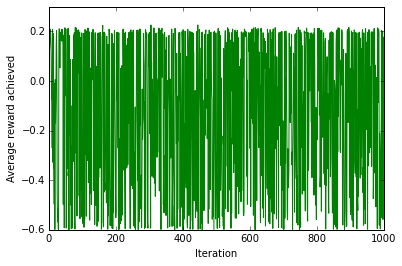

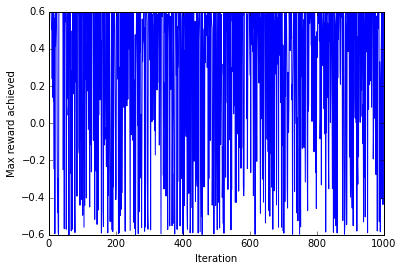

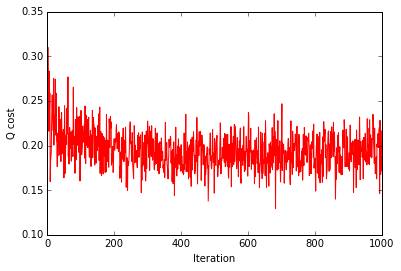

In [28]:
plt.figure(1)
plt.plot(avg_rewards, "g")
plt.xlabel("Iteration")
plt.ylabel("Average reward achieved")

plt.figure(2)
plt.plot(max_rewards, "b")
plt.xlabel("Iteration")
plt.ylabel("Max reward achieved")

plt.figure(3)
plt.plot(q_costs, "r")
plt.xlabel("Iteration")
plt.ylabel("Q cost")

In [ ]:
states = [state for state, _, _, _
          in mdp.sample_transition(100, lambda s: dpg.f_action_on(s.reshape((-1, STATE_DIM))))]
states = np.array(states)
mdp.animate_trace(states).save("test.mp4")
plt.clf()